This notebook runs a `Qallse` model using [_qbsolv_](https://github.com/dwavesystems/qbsolv) and a D-Wave solver. This means that both classical and quantum algorithms are deployed to find the best solution.

**Important**: this example requires the *ocean SDK* and a valid configuration:

```python
pip install dwave-ocean-sdk && dwave config create
```

If you don't have a D-Wave, you can create a free **Leap account** [here](https://cloud.dwavesys.com/leap/).

# Import and setup

In [1]:
# import modules
import pandas as pd
import numpy as np

from hepqpr.qallse.plotting import *
from hepqpr.qallse import *

# import D-Wave modules
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

# initialise the plotting module in "notebook" mode
set_notebook_mode()

# initialise matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# initialise the logging module
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger('hepqpr').setLevel(logging.DEBUG)
logging.getLogger('hepqpr.qallse.track_recreater').setLevel(logging.INFO)
logging.getLogger('dwave_qbsolv').setLevel(logging.DEBUG)

In [2]:
# setup matplotlib
import matplotlib

# set big font in plots
SMALL_SIZE = 14
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

# Define run config

In [3]:
# == INPUT CONFIG

# path to the input dataset
path = '/tmp/data-collapse/barrel_phi1.05-2.01_80/event000001000' 
# whether or not to add missing doublets to the input
add_missing = False 

# == RUN CONFIG

model_class = Qallse # model class to use
extra_config = dict() # configuration arguments overriding the defaults

# == QBSOLV/D-Wave specific


# Those arguments allows us to spare QPU time. If you don't have a limited access, increase all values
qbsolv_arguments = dict(
    timeout = 4*60,   # timeout after 4 minutes
    num_reads = 10,   # sample a sub-QUBO 10 times on the D-Wave
    num_repeats = 10, # run qbsolv's outer loop at most 10 times
    verbosity = 1,    # between 0 and 3
)

# path to the dwave.conf configuration file (created using dwave-config create)
dwave_conf = '/Users/lin/git/quantum-annealing-project/dwave-leap/conf/dwave.conf'

# D-Wave solver used by qbsolv for the sampling of sub-QUBOs
sampler = DWaveSampler(config_file=dwave_conf)
solver = EmbeddingComposite(sampler)

# IMPORTANT NOTE: uncomment the following line to run on simulation (no D-Wave)
solver = None

print(f'using sampler {sampler.solver}')

using sampler Solver(id='DW_2000Q_2_1')


# Execute the model

## Load the data

In [4]:
# load data
dw = DataWrapper.from_path(path)
doublets = pd.read_csv(path + '-doublets.csv')
if add_missing:
    doublets = dw.add_missing_doublets(doublets)
else:
    p, r, ms = dw.compute_score(doublets)
    print(f'got {len(doublets)}.')
    print(f'  Input precision (%): {p*100:.4f}, recall (%): {r*100:.4f}, missing: {len(ms)}')

got 18317.
  Input precision (%): 2.4513, recall (%): 93.7370, missing: 30


## Build the model

In [5]:
%%time

# instantiate qallse
model = model_class(dw, **extra_config)
# build the qubo
model.build_model(doublets=doublets)
Q = model.to_qubo()

DEBUG:hepqpr.qallse.qallse:using config:
DEBUG:hepqpr.qallse.qallse:    cheat: False
DEBUG:hepqpr.qallse.qallse:    max_layer_span: 2
DEBUG:hepqpr.qallse.qallse:    num_multiplier: -1
DEBUG:hepqpr.qallse.qallse:    qplet_max_dcurv: 0.0005
DEBUG:hepqpr.qallse.qallse:    qplet_max_strength: -0.2
DEBUG:hepqpr.qallse.qallse:    qubo_bias_weight: -0.01
DEBUG:hepqpr.qallse.qallse:    qubo_conflict_strength: 0.5
DEBUG:hepqpr.qallse.qallse:    rz_power: 1
DEBUG:hepqpr.qallse.qallse:    strength_bounds: None
DEBUG:hepqpr.qallse.qallse:    tplet_max_curv: 0.005
DEBUG:hepqpr.qallse.qallse:    tplet_max_drz: 0.2
DEBUG:hepqpr.qallse.qallse:    volayer_power: 2
DEBUG:hepqpr.qallse.qallse:    xy_power: 1
DEBUG:hepqpr.qallse.qallse:    xy_relative_strength: 0.5
INFO:hepqpr.qallse.qallse:created 10570 doublets.
INFO:hepqpr.qallse.qallse:created 23903 triplets.
INFO:hepqpr.qallse.qallse:created 1504 quadruplets.
INFO:hepqpr.qallse.qallse:Model built in 3.34s. doublets: 1711, triplets: 1813, quadruplets:

CPU times: user 3.58 s, sys: 35.6 ms, total: 3.62 s
Wall time: 3.61 s


## Sample the QUBO

Here, we use [_qbsolv_](https://github.com/dwavesystems/qbsolv) with default arguments. This means only classical algorithms.

In [6]:
%%time
# execute the qubo
response = model.sample_qubo(Q=Q, **qbsolv_arguments)

DEBUG:dwave_qbsolv.qbsolv_binding:params.repeats = 10
DEBUG:dwave_qbsolv.qbsolv_binding:Using built-in tabu sub-problem solver.
DEBUG:dwave_qbsolv.qbsolv_binding:setting random seed to 348508080
INFO:hepqpr.qallse.qallse:QUBO of size 30582 sampled in 2.70s.


CPU times: user 2.55 s, sys: 150 ms, total: 2.7 s
Wall time: 2.7 s


## Process all sample

In [7]:
%%time 

en0 = dw.compute_energy(Q)

samples = list(response.samples())
occurrences = response.record.num_occurrences
energies = response.record.energy

solutions = []
csv_rows = ['idx,occ,energy,energy_gap,p,r,ms,trackml,conflicts,num_tracks']

for i, (sample, en, occ) in enumerate(zip(samples, energies, occurrences)):
    all_doublets = model.process_sample(sample)
    tr = TrackRecreaterD()
    final_tracks, final_doublets = tr.process_results(all_doublets)
    
    # scores
    p, r, ms = dw.compute_score(final_doublets)
    trackml = dw.compute_trackml_score(final_tracks)

    csv_rows.extend([f'{i},{occ},{en},{en-en0},{p},{r},{len(ms)},{trackml},{len(tr.conflicts)},{len(final_tracks)}'] * occ)
    solutions.append((final_doublets, final_tracks, ms))

stats = pd_read_csv_array(csv_rows)

INFO:hepqpr.qallse.track_recreater:Found 4 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 2 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 6 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 3 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 9 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 5 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 6 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 3 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 6 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 3 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 6 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 3 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 6 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added 3 conflicting segments
INFO:hepqpr.qallse.track_recreater:Found 8 conflicting segments
INFO:hepqpr.qallse.track_recreater:Added

CPU times: user 936 ms, sys: 35 ms, total: 971 ms
Wall time: 965 ms


# Evaluate the results

## View samples statistics

In [8]:
stats.drop_duplicates('idx').sort_values('occ', ascending=False).round(4)

,idx,occ,energy,energy_gap,p,r,ms,trackml,conflicts,num_tracks
0,0,9,-258.8546,-0.4085,1.0000,0.9040,46,0.9473,4,74
18,8,5,-257.8553,0.5908,0.9954,0.8998,48,0.9382,4,74
25,10,3,-257.7743,0.6717,0.9908,0.8956,50,0.9366,4,74
11,2,2,-258.7485,-0.3024,0.9977,0.9019,47,0.9457,9,75
23,9,2,-257.8036,0.6424,0.9931,0.8956,50,0.9298,6,74
9,1,2,-258.8030,-0.3569,0.9977,0.8998,48,0.9389,6,74
31,14,2,-257.6975,0.7485,0.9907,0.8935,51,0.9282,11,75
13,3,1,-258.7475,-0.3015,0.9977,0.8998,48,0.9424,6,74
30,13,1,-257.7227,0.7234,0.9884,0.8914,52,0.9281,6,74
36,18,1,-255.0229,3.4232,0.9885,0.8935,51,0.9306,9,75


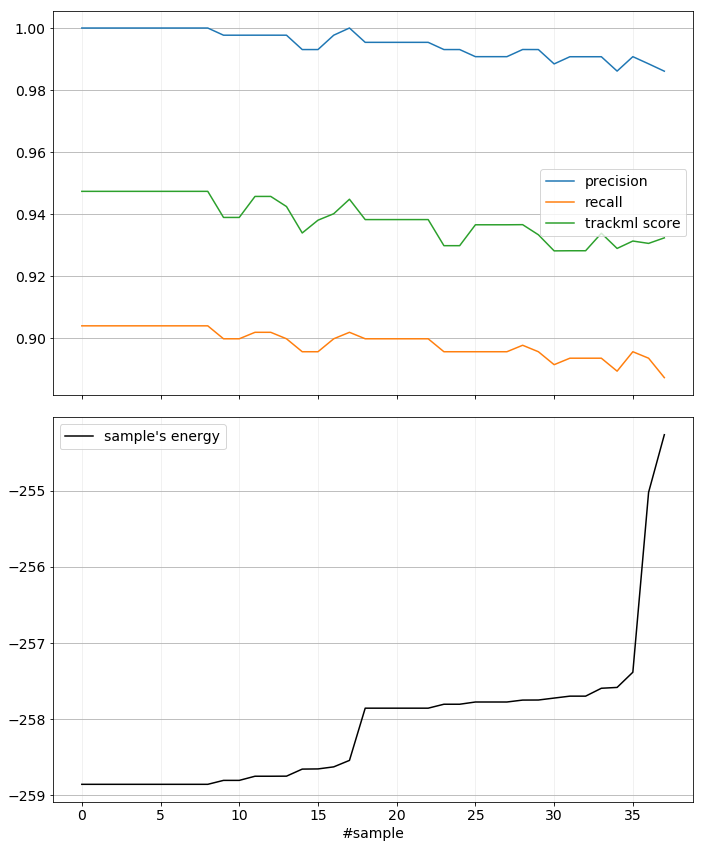

In [9]:
fig = plt.figure(figsize=(10, 12))
axes = fig.subplots(2, sharex=True)

stats.p.plot(ax=axes[0], label='precision')
stats.r.plot(ax=axes[0], label='recall')
stats.trackml.plot(ax=axes[0], label='trackml score')

stats.energy.plot(ax=axes[1], color='black', label='sample\'s energy')
#plt.xticks([0, 1, 6, 7, 13, 14, 18, 19])
plt.xlabel('#sample')
for ax in axes: 
    ax.legend()
    ax.yaxis.grid()
    ax.xaxis.grid(color='#eeeeee')
plt.tight_layout()
_ = _

## Plot the best trackml result found


In [10]:
_, serie = next(stats[stats.trackml == stats.trackml.max()].iterrows())

final_doublets, final_tracks, missings = solutions[int(serie.idx)]

print(f'Best trackml score found in sample {serie.idx:.0f}:')
print(f'   occ: {serie.occ:.0f}, en: {serie.energy}')
print(f'   p: {serie.p*100:.3f}, r: {serie.r*100:.3f}')
print(f'   trackml: {serie.trackml*100:.3f} ({serie.num_tracks:.0f} tracks found)')
print()

Best trackml score found in sample 0:
   occ: 9, en: -258.85461230298137
   p: 100.000, r: 90.397
   trackml: 94.733 (74 tracks found)



In [11]:
iplot_results(dw, final_doublets, missing=missings, dims=list('zxy'))

In [12]:
iplot_results_tracks(dw, final_tracks, dims=list('zxy'))

## Plot the worst trackml result found

In [13]:
_, serie = next(stats[stats.trackml == stats.trackml.min()].iterrows())

final_doublets, final_tracks, missings = solutions[int(serie.idx)]

print(f'Worst trackml score found in sample {serie.idx:.0f}:')
print(f'   occ: {serie.occ:.0f}, en: {serie.energy}')
print(f'   p: {serie.p*100:.3f}, r: {serie.r*100:.3f}')
print(f'   trackml: {serie.trackml*100:.3f} ({serie.num_tracks:.0f} tracks found)')
print()

Worst trackml score found in sample 13:
   occ: 1, en: -257.72269296150347
   p: 98.843, r: 89.144
   trackml: 92.814 (74 tracks found)



In [14]:
iplot_results_tracks(dw, final_tracks, dims=list('zxy'))